In [2]:
import os
import pandas as pd
import wget
import sys
import subprocess
from subprocess import call
import matplotlib.pyplot as plt
import seaborn 
import random
%matplotlib inline

import json

import numpy as np

from metamind.api import ClassificationData, ClassificationModel, set_api_key

sys.path.append(os.environ["HOME"])
from ds_config import *

print os.environ["HOME"]
MAIN_PATH = os.environ["HOME"]+"/GLaDOS_Workspace/"
#os.mkdir(MAIN_PATH)
#os.mkdir(MAIN_PATH+"Videos/")
#os.mkdir(MAIN_PATH+"Images/")

seaborn.set_style("white")

/Users/williamspearman


# FFMPEG Scrips

In [14]:
def getVideoInfo(file_name):
    bashCommand = "ffprobe -show_streams " + file_name
    process = subprocess.Popen(bashCommand.split(" "), stdout=subprocess.PIPE)
    output = process.communicate()[0].split("\n")
    ret_dict = { }
    for x in output:
        if "=" in x:
            key_vals = x.split("=")
            ret_dict[key_vals[0]] = key_vals[1]
    #print ret_dict
    return ret_dict

def getRandInt(int1, int2):
    if int1[0]>=int1[1]:
        return np.random.randint(int2[0],int2[1])
    elif int2[0]>=int2[1]:
        return np.random.randint(int1[0],int1[1])
    
    if np.random.random() > 0.5:
        return np.random.randint(int1[0],int1[1])
    else:
        return np.random.randint(int2[0],int2[1])

    

def getClipTriplets(file_name, snap_time, pm_secs=1.):
    ret_val = { }
    info_dict = getVideoInfo(file_name)
    required_vals = { "duration", "nb_frames", "avg_frame_rate", "sample_aspect_ratio" }
    if len(required_vals.intersection(set(info_dict.keys())))!=len(required_vals):
        return None
    frame_rate = 0.
    try:
        frame_rate = float(info_dict["avg_frame_rate"].split("/")[0])/float(info_dict["avg_frame_rate"].split("/")[1])
    except:
        return None
    num_frames = float(info_dict["nb_frames"])
    duration = float(info_dict["duration"])

    if int(num_frames/frame_rate-duration)!= 0:
        return None
    
    pm_frames = pm_secs * frame_rate
    snap_frame = snap_time * frame_rate
    
    snap_frame_low = 0.
    snap_frame_med = snap_frame_low+1.*pm_frames
    snap_frame_high = snap_frame_low+2.*pm_frames
    while snap_frame_high<=num_frames:
        ret_val["TIME_%i" % (snap_frame_med)] = \
        [ snap_frame_low/frame_rate, snap_frame_med/frame_rate, snap_frame_high/frame_rate ]
        snap_frame_low += pm_frames
        snap_frame_med += pm_frames
        snap_frame_high += pm_frames
    
    
    return ret_val
    
def downloadUrl(url):
    base_name = ""
    try:
        base_name = url.split("/")[-1]
    except:
        return ""
    
    output_name = MAIN_PATH + "Videos/" + base_name
    if os.path.isfile(output_name)==False:
        wget.download(url, MAIN_PATH+"Videos/")
    
    if os.path.isfile(output_name)==True:
        return output_name
    else:
        return ""


def getGetSignalBkgTriplets(file_name, snap_time, pm_secs=1.):
    ret_val = { }
    info_dict = getVideoInfo(file_name)
    required_vals = { "duration", "nb_frames", "avg_frame_rate", "sample_aspect_ratio" }
    if len(required_vals.intersection(set(info_dict.keys())))!=len(required_vals):
        return None
    frame_rate = 0.
    try:
        frame_rate = float(info_dict["avg_frame_rate"].split("/")[0])/float(info_dict["avg_frame_rate"].split("/")[1])
    except:
        return None
    num_frames = float(info_dict["nb_frames"])
    duration = float(info_dict["duration"])

    if int(num_frames/frame_rate-duration)!= 0:
        return None
    
    pm_frames = pm_secs * frame_rate
    snap_frame = snap_time * frame_rate
    
    snap_frame_low = snap_frame-pm_frames
    snap_frame_high = snap_frame+pm_frames
    if snap_frame_low<0:
        return None
    if snap_frame_high>num_frames:
        return None
    
    int1 = [ pm_frames, max(0,snap_frame_low-pm_frames) ]
    int2 = [ min(pm_frames+snap_frame_high, num_frames), num_frames-pm_frames ]
    bkg_frame = getRandInt(int1, int2)
    
    ret_val["SNAP"] = [ snap_frame_low/frame_rate, snap_frame/frame_rate, snap_frame_high/frame_rate ]
    ret_val["NOT_SNAP"] = [ (bkg_frame-pm_frames)/frame_rate, bkg_frame/frame_rate, (bkg_frame+pm_frames)/frame_rate ]
    
    return ret_val
    
def downloadUrl(url):
    base_name = ""
    try:
        base_name = url.split("/")[-1]
    except:
        return ""
    
    output_name = MAIN_PATH + "Videos/" + base_name
    if os.path.isfile(output_name)==False:
        wget.download(url, MAIN_PATH+"Videos/")
    
    if os.path.isfile(output_name)==True:
        return output_name
    else:
        return ""



def makeImageMontage(url, snap_time, time_offset=0.5, triplets=True):
    ret_val = [ ]
    video_path = downloadUrl(url)
    #print "BLah %f" % 0.2
    base_name = ""
    try:
        base_name = video_path.split("/")[-1].split(".")[0]
    except:
        print "Failed splitting: %s" % video_path
        return None
    input_times = None
    if triplets:
        input_times = getGetSignalBkgTriplets(video_path, snap_time, time_offset)
    else:
        input_times = getClipTriplets(video_path, snap_time, time_offset)
    if input_times==None:
        return ret_val
    #resolution = resolution.replace(":", "x")
    #name1 = "blah"
    #name2 = "blah"
    ffmpeg_cmds = { }
    file_names = { }
    for mykey in input_times.keys():
        output_name = MAIN_PATH + "Images/" + base_name
        ffmpeg_cmds[mykey] = [ ]
        file_names[mykey] = [ ]
        for x, i in zip(input_times[mykey], range(0,len(input_times[mykey]))):
            file_name = "%s_%i_%s.jpg" % (output_name, i, mykey)
            file_names[mykey].append(file_name)
            ffmpeg_cmds[mykey].append("ffmpeg -ss %f -i %s -vframes 1 %s 2> /dev/null" % (x, video_path, file_name))
        #montage_cmd = "montage -tile 1x3 -geometry 512x256+0+0 "
        montage_cmd = "montage -tile 1x3 -geometry 512x+0+0 "
        for thecmd, fname in zip(ffmpeg_cmds[mykey], file_names[mykey]):
            call(thecmd, shell=True)
            montage_cmd = montage_cmd+fname+" "
        montage_name = "%s_%i_%s_MONTAGE.jpg" % (output_name, int(1000*input_times[mykey][1]), mykey)
        montage_cmd = montage_cmd + " " + montage_name
        call(montage_cmd,shell=True)
        for fname in file_names[mykey]:
            try:
                os.remove(fname)
            except:
                print "Couldn't remove %s" % fname
        ret_val.append((montage_name, mykey))
        
        
        
            
    return ret_val


In [4]:
set_api_key(metamind_api_key)
classifier = ClassificationModel(id=18410)

Hello, Ben Cook


In [12]:
files_to_run

[(5.806,
  u'http://va.hudl.com/sti/8zc/a67e7fc5-a01e-46cd-9303-4253c344a9a4/ijiqcnmcrkjan0pz_1100.mp4'),
 (3.136,
  u'http://vc.hudl.com/ypv/ans/6c55878e-9a55-4e0d-815a-e04289823f3b/tmmgnfe6tka9let1-3000.mp4'),
 (4.471,
  u'http://vb.hudl.com/nse/jl6/0c93a3cc-fc9c-4eea-9dd4-febf4bd22cce/149-2yvv.mp4'),
 (5.806,
  u'http://vd.hudl.com/hqa/6gs/3fd7c5d3-6dc2-4821-a866-3338959cbbdd/s7vgdbn49wfqc4iw-1100.mp4'),
 (3.47,
  u'http://vd.hudl.com/efv/d6f/7deb7d2c-5b8d-4907-96b1-749252732a73/013-wvh5.mp4'),
 (2.469,
  u'http://vi.hudl.com/ck0/c7w/e7dc4151-92ad-4a83-a9d7-ff818e059b8b/nwl6hdat4ze7aaqc-1100.mp4'),
 (4.137,
  u'http://vi.hudl.com/zqx/qqj/a7087792-20e8-4ff0-99ee-598d97e3393b/nswpopl0fxicsqf8-1100.mp4'),
 (7.808,
  u'http://vd.hudl.com/r4m/m13/e8852f6b-ec6a-4012-99ae-c165d43f7b00/ltgrsqe7s12olgeo-3000.mp4'),
 (11.478,
  u'http://va.hudl.com/5km/wri/ffe33c28-6a5f-441c-a0bc-f3d85a878149/ryede2r0sefgvqte-1100.mp4'),
 (11.478,
  u'http://vj.hudl.com/je3/zt0/ae9fbf88-93dd-4dda-86d4-1622f89

In [13]:
singleClips

NameError: name 'singleClips' is not defined

In [15]:
#singleClips = makeImageMontage("http://vf.hudl.com/9n6/81k/bab387d7-c875-4df6-89f7-3a0c910deb6a/lelyp36kuaykgm1j-3000_1100.mp4", 8.809, 0.5, False)

def DetectSnap(url, snap_time, time_offset=1.):
    base_name = url.split("/")[-1].split(".mp4")[0]
    singleClips = makeImageMontage(url, snap_time, time_offset, False)
    classifier = ClassificationModel(id=18410)

    predictions = [ ]

    length = len(singleClips)
    if length<=0:
        return
    for x, i in zip(singleClips, range(0,length)):
        print "On %i of %i" % (i, length)
        print x
        time = float(x[1].split("_")[-1])
        #time = (float(x[1].split("_")[-1])+float(x[1].split("_")[-2]))/2.
        result = classifier.predict(x[0], input_type="files")
        prediction = result[0]['label']
        prob_snap=0.
        if prediction=="SNAP":
            prob_snap=result[0]["probability"]
        else:
            prob_snap=1-result[0]["probability"]
        print "Probability %f for time %f" % (prob_snap, time)
        predictions.append( (time, prob_snap) )
        
    predictions = sorted(predictions)
    np_arr = np.array(predictions)

    x = [ ]

    for tmp in np_arr[:,0]:
        x.append(tmp/30.)
    y = np_arr[:,1]
    #print x
    #print y

    #x2 = [ 8.809 ]
    #y2 = [ 1. ]

    plt.plot(x,y)
    plt.axvline(snap_time, color='r', linestyle='dashed', linewidth=2) 
    plt.xlabel('Seconds', fontsize=12)
    plt.ylabel('Probability of Snap', fontsize=12)
    #plt.show()
    plt.savefig("SnapProbability_%s.png" % base_name)
    plt.show()
    return np_arr

In [16]:
formationRDD = sc.textFile("s3n://hudl-hadoop/GLaDOS/formation_data/").map(json.loads)

In [17]:
files_to_run = formationRDD.map(lambda x: (x["video"]["snap time"], x["video"]["urls"][0])).takeSample(False,10)
random.shuffle(files_to_run)

On 0 of 38
(u'/Users/williamspearman/GLaDOS_Workspace/Images/avgnnbuzlidqzaq9-1100_1500_TIME_45_MONTAGE.jpg', 'TIME_45')
Probability 0.513789 for time 45.000000
On 1 of 38
(u'/Users/williamspearman/GLaDOS_Workspace/Images/avgnnbuzlidqzaq9-1100_10000_TIME_300_MONTAGE.jpg', 'TIME_300')
Probability 0.561646 for time 300.000000
On 2 of 38
(u'/Users/williamspearman/GLaDOS_Workspace/Images/avgnnbuzlidqzaq9-1100_8000_TIME_240_MONTAGE.jpg', 'TIME_240')
Probability 0.526145 for time 240.000000
On 3 of 38
(u'/Users/williamspearman/GLaDOS_Workspace/Images/avgnnbuzlidqzaq9-1100_12000_TIME_360_MONTAGE.jpg', 'TIME_360')
Probability 0.523285 for time 360.000000
On 4 of 38
(u'/Users/williamspearman/GLaDOS_Workspace/Images/avgnnbuzlidqzaq9-1100_6000_TIME_180_MONTAGE.jpg', 'TIME_180')
Probability 0.534889 for time 180.000000
On 5 of 38
(u'/Users/williamspearman/GLaDOS_Workspace/Images/avgnnbuzlidqzaq9-1100_2000_TIME_60_MONTAGE.jpg', 'TIME_60')
Probability 0.514581 for time 60.000000
On 6 of 38
(u'/Users

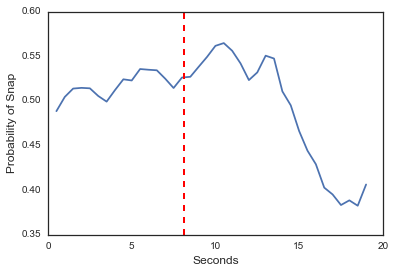

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/udsiy1i6iunblzru-1100_2_TIME_300.jpg
On 0 of 20
(u'/Users/williamspearman/GLaDOS_Workspace/Images/udsiy1i6iunblzru-1100_1500_TIME_45_MONTAGE.jpg', 'TIME_45')
Probability 0.539403 for time 45.000000
On 1 of 20
(u'/Users/williamspearman/GLaDOS_Workspace/Images/udsiy1i6iunblzru-1100_5500_TIME_165_MONTAGE.jpg', 'TIME_165')
Probability 0.397187 for time 165.000000
On 2 of 20
(u'/Users/williamspearman/GLaDOS_Workspace/Images/udsiy1i6iunblzru-1100_8500_TIME_255_MONTAGE.jpg', 'TIME_255')
Probability 0.294937 for time 255.000000
On 3 of 20
(u'/Users/williamspearman/GLaDOS_Workspace/Images/udsiy1i6iunblzru-1100_2000_TIME_60_MONTAGE.jpg', 'TIME_60')
Probability 0.549040 for time 60.000000
On 4 of 20
(u'/Users/williamspearman/GLaDOS_Workspace/Images/udsiy1i6iunblzru-1100_8000_TIME_240_MONTAGE.jpg', 'TIME_240')
Probability 0.323545 for time 240.000000
On 5 of 20
(u'/Users/williamspearman/GLaDOS_Workspace/Images/udsiy1i6iunblzru-1100_350

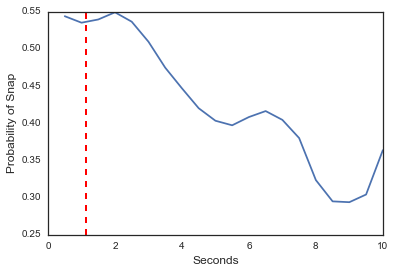

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/njd43hhiebpzuhtk-1100_2_TIME_360.jpg
On 0 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/njd43hhiebpzuhtk-1100_1500_TIME_45_MONTAGE.jpg', 'TIME_45')
Probability 0.561703 for time 45.000000
On 1 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/njd43hhiebpzuhtk-1100_10000_TIME_300_MONTAGE.jpg', 'TIME_300')
Probability 0.507136 for time 300.000000
On 2 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/njd43hhiebpzuhtk-1100_8000_TIME_240_MONTAGE.jpg', 'TIME_240')
Probability 0.577444 for time 240.000000
On 3 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/njd43hhiebpzuhtk-1100_12000_TIME_360_MONTAGE.jpg', 'TIME_360')
Probability 0.456491 for time 360.000000
On 4 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/njd43hhiebpzuhtk-1100_6000_TIME_180_MONTAGE.jpg', 'TIME_180')
Probability 0.646839 for time 180.000000
On 5 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/njd43hhiebpzuhtk-110

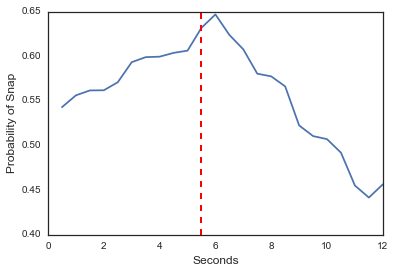

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/keojqrpj7lxjhdb1-1100_2_TIME_510.jpg
On 0 of 34
(u'/Users/williamspearman/GLaDOS_Workspace/Images/keojqrpj7lxjhdb1-1100_1500_TIME_45_MONTAGE.jpg', 'TIME_45')
Probability 0.427498 for time 45.000000
On 1 of 34
(u'/Users/williamspearman/GLaDOS_Workspace/Images/keojqrpj7lxjhdb1-1100_10000_TIME_300_MONTAGE.jpg', 'TIME_300')
Probability 0.517124 for time 300.000000
On 2 of 34
(u'/Users/williamspearman/GLaDOS_Workspace/Images/keojqrpj7lxjhdb1-1100_8000_TIME_240_MONTAGE.jpg', 'TIME_240')
Probability 0.535649 for time 240.000000
On 3 of 34
(u'/Users/williamspearman/GLaDOS_Workspace/Images/keojqrpj7lxjhdb1-1100_12000_TIME_360_MONTAGE.jpg', 'TIME_360')
Probability 0.424993 for time 360.000000
On 4 of 34
(u'/Users/williamspearman/GLaDOS_Workspace/Images/keojqrpj7lxjhdb1-1100_6000_TIME_180_MONTAGE.jpg', 'TIME_180')
Probability 0.481570 for time 180.000000
On 5 of 34
(u'/Users/williamspearman/GLaDOS_Workspace/Images/keojqrpj7lxjhdb1-110

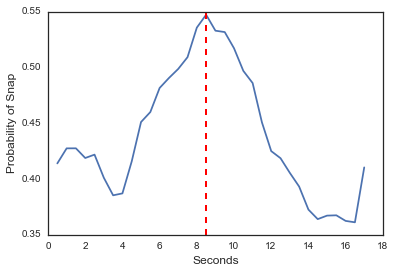

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/034-cp5q_2_TIME_434.jpg
On 0 of 29
(u'/Users/williamspearman/GLaDOS_Workspace/Images/034-cp5q_3000_TIME_89_MONTAGE.jpg', 'TIME_89')
Probability 0.638915 for time 89.000000
On 1 of 29
(u'/Users/williamspearman/GLaDOS_Workspace/Images/034-cp5q_1500_TIME_44_MONTAGE.jpg', 'TIME_44')
Probability 0.578239 for time 44.000000
On 2 of 29
(u'/Users/williamspearman/GLaDOS_Workspace/Images/034-cp5q_11000_TIME_329_MONTAGE.jpg', 'TIME_329')
Probability 0.479444 for time 329.000000
On 3 of 29
(u'/Users/williamspearman/GLaDOS_Workspace/Images/034-cp5q_7000_TIME_209_MONTAGE.jpg', 'TIME_209')
Probability 0.642080 for time 209.000000
On 4 of 29
(u'/Users/williamspearman/GLaDOS_Workspace/Images/034-cp5q_7500_TIME_224_MONTAGE.jpg', 'TIME_224')
Probability 0.657971 for time 224.000000
On 5 of 29
(u'/Users/williamspearman/GLaDOS_Workspace/Images/034-cp5q_1000_TIME_29_MONTAGE.jpg', 'TIME_29')
Probability 0.562592 for time 29.000000
On 6 of 29
(u'/

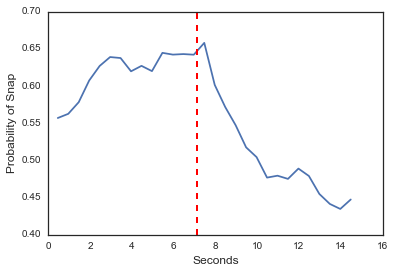

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/py405urcill7c44e_3000_2_TIME_344.jpg
On 0 of 23
(u'/Users/williamspearman/GLaDOS_Workspace/Images/py405urcill7c44e_3000_3000_TIME_89_MONTAGE.jpg', 'TIME_89')
Probability 0.561126 for time 89.000000
On 1 of 23
(u'/Users/williamspearman/GLaDOS_Workspace/Images/py405urcill7c44e_3000_1500_TIME_44_MONTAGE.jpg', 'TIME_44')
Probability 0.585136 for time 44.000000
On 2 of 23
(u'/Users/williamspearman/GLaDOS_Workspace/Images/py405urcill7c44e_3000_11000_TIME_329_MONTAGE.jpg', 'TIME_329')
Probability 0.323956 for time 329.000000
On 3 of 23
(u'/Users/williamspearman/GLaDOS_Workspace/Images/py405urcill7c44e_3000_7000_TIME_209_MONTAGE.jpg', 'TIME_209')
Probability 0.469196 for time 209.000000
On 4 of 23
(u'/Users/williamspearman/GLaDOS_Workspace/Images/py405urcill7c44e_3000_7500_TIME_224_MONTAGE.jpg', 'TIME_224')
Probability 0.464032 for time 224.000000
On 5 of 23
(u'/Users/williamspearman/GLaDOS_Workspace/Images/py405urcill7c44e_3000_10

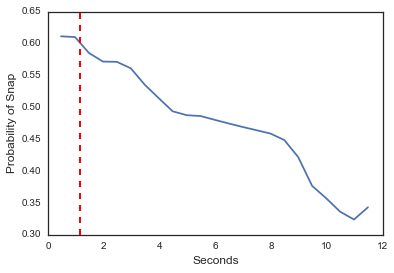

On 0 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/vl71lndpxtnk9dte-1100_1500_TIME_45_MONTAGE.jpg', 'TIME_45')
Probability 0.491107 for time 45.000000
On 1 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/vl71lndpxtnk9dte-1100_10000_TIME_300_MONTAGE.jpg', 'TIME_300')
Probability 0.491850 for time 300.000000
On 2 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/vl71lndpxtnk9dte-1100_8000_TIME_240_MONTAGE.jpg', 'TIME_240')
Probability 0.386454 for time 240.000000
On 3 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/vl71lndpxtnk9dte-1100_12000_TIME_360_MONTAGE.jpg', 'TIME_360')
Probability 0.481964 for time 360.000000
On 4 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/vl71lndpxtnk9dte-1100_6000_TIME_180_MONTAGE.jpg', 'TIME_180')
Probability 0.407954 for time 180.000000
On 5 of 24
(u'/Users/williamspearman/GLaDOS_Workspace/Images/vl71lndpxtnk9dte-1100_2000_TIME_60_MONTAGE.jpg', 'TIME_60')
Probability 0.451820 for time 60.000000
On 6 of 24
(u'/Users

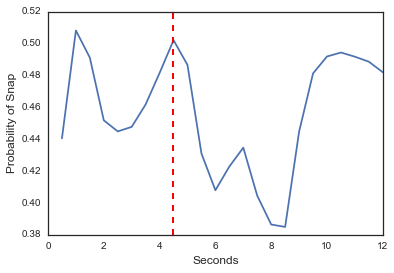

On 0 of 33
(u'/Users/williamspearman/GLaDOS_Workspace/Images/pk9ce6ib1g6dpmur-3000_1500_TIME_45_MONTAGE.jpg', 'TIME_45')
Probability 0.461619 for time 45.000000
On 1 of 33
(u'/Users/williamspearman/GLaDOS_Workspace/Images/pk9ce6ib1g6dpmur-3000_10000_TIME_300_MONTAGE.jpg', 'TIME_300')
Probability 0.489997 for time 300.000000
On 2 of 33
(u'/Users/williamspearman/GLaDOS_Workspace/Images/pk9ce6ib1g6dpmur-3000_8000_TIME_240_MONTAGE.jpg', 'TIME_240')
Probability 0.480184 for time 240.000000
On 3 of 33
(u'/Users/williamspearman/GLaDOS_Workspace/Images/pk9ce6ib1g6dpmur-3000_12000_TIME_360_MONTAGE.jpg', 'TIME_360')
Probability 0.456031 for time 360.000000
On 4 of 33
(u'/Users/williamspearman/GLaDOS_Workspace/Images/pk9ce6ib1g6dpmur-3000_6000_TIME_180_MONTAGE.jpg', 'TIME_180')
Probability 0.467524 for time 180.000000
On 5 of 33
(u'/Users/williamspearman/GLaDOS_Workspace/Images/pk9ce6ib1g6dpmur-3000_2000_TIME_60_MONTAGE.jpg', 'TIME_60')
Probability 0.468403 for time 60.000000
On 6 of 33
(u'/Users

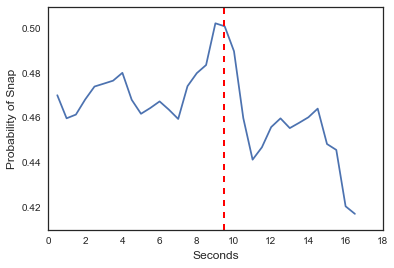

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/ihsstuupsnjkvuoc-3000_2_TIME_330.jpg
On 0 of 22
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ihsstuupsnjkvuoc-3000_1500_TIME_45_MONTAGE.jpg', 'TIME_45')
Probability 0.476008 for time 45.000000
On 1 of 22
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ihsstuupsnjkvuoc-3000_10000_TIME_300_MONTAGE.jpg', 'TIME_300')
Probability 0.383045 for time 300.000000
On 2 of 22
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ihsstuupsnjkvuoc-3000_8000_TIME_240_MONTAGE.jpg', 'TIME_240')
Probability 0.386572 for time 240.000000
On 3 of 22
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ihsstuupsnjkvuoc-3000_6000_TIME_180_MONTAGE.jpg', 'TIME_180')
Probability 0.520283 for time 180.000000
On 4 of 22
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ihsstuupsnjkvuoc-3000_2000_TIME_60_MONTAGE.jpg', 'TIME_60')
Probability 0.487694 for time 60.000000
On 5 of 22
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ihsstuupsnjkvuoc-3000_50

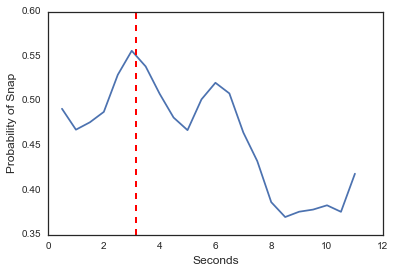

In [18]:
data = [ ]

for x in files_to_run:
    data.append(DetectSnap(x[1],x[0],0.5))